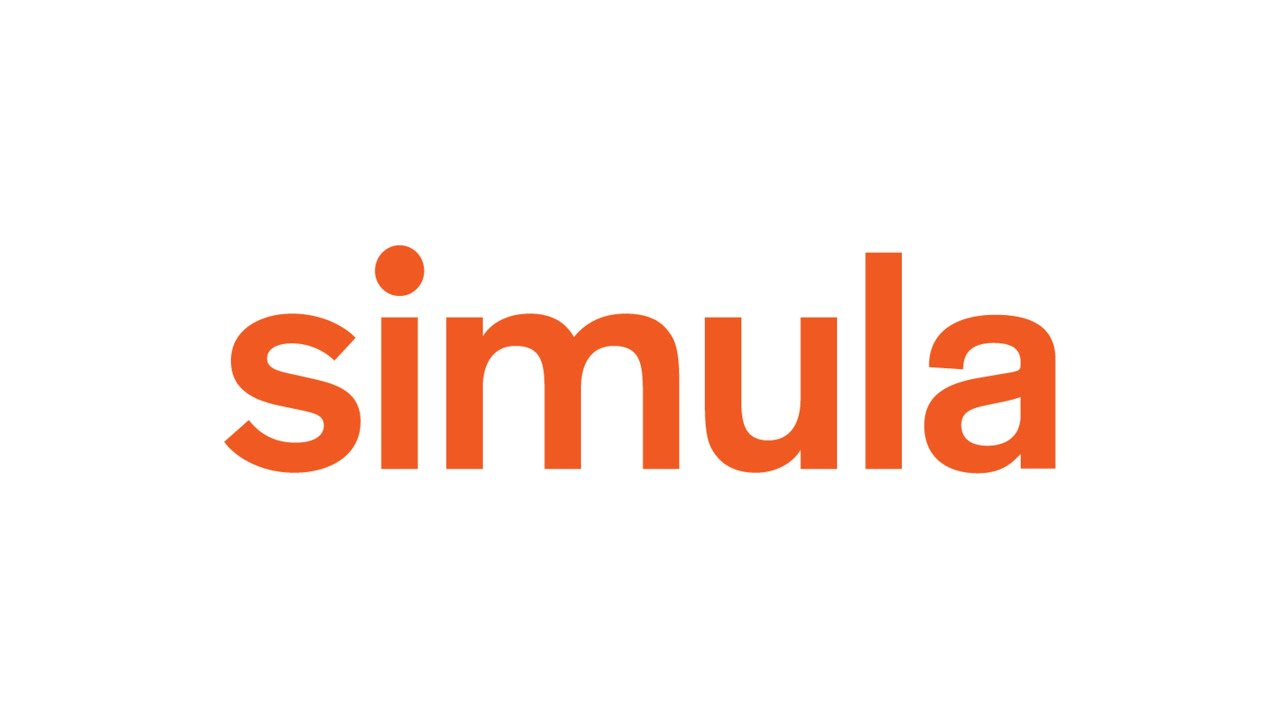

# <center>Peristaltic Flow Script</center>

This script allows the user to compute an estimate of net flow in a perivascular network, which is critical for understanding the transport of molcules in and around the human brain. Image data were downloaded from Hodneland et al, PLOS Comp. Bio, 2023, which can be read in full [here](https://doi.org/10.1371/journal.pcbi.1007073).

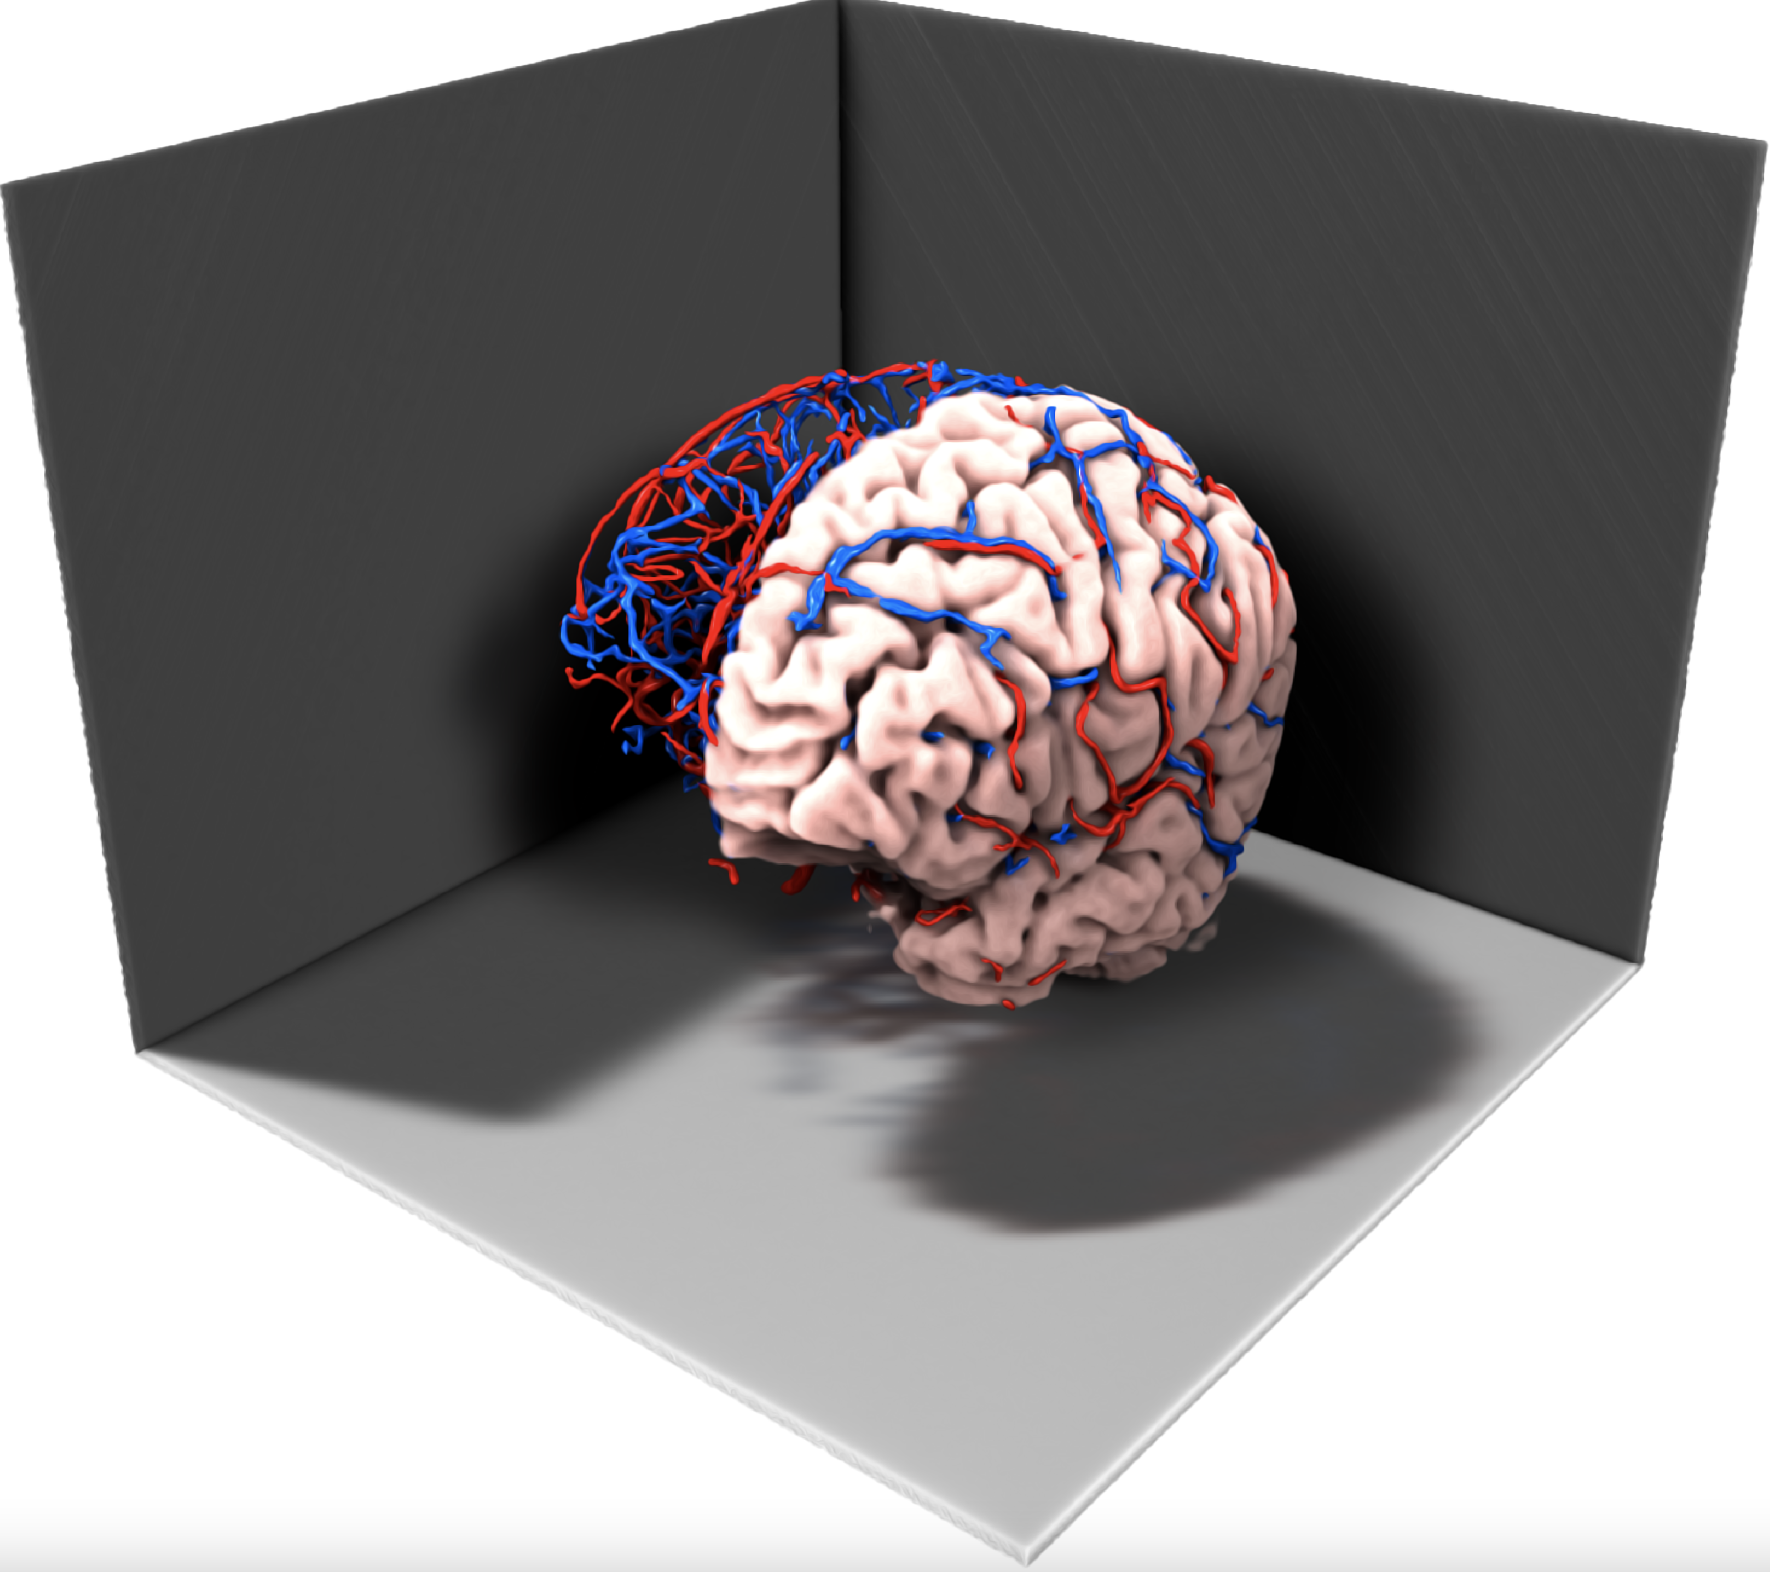

# Fluid Flow in Perivascular Spaces (PVS) Simulation

Below you can interactively simulate the fluid flow in perivascular spaces! 

## Input Variables 

Below, you will find the variables that you can adjust to simulate the flow in a perivascular network. 

<div class="alert alert-block alert-info">
    
<b>Frequency =</b> Vascular wave frequency (Hz)<br>
<b>Wavelength =</b> Vascular wave wavelength (mm)<br>
<b>Amplitude =</b> Vascular wave relative amplitude (relative to (inner) vascular radius)<br>
<b>Beta =</b> Ratio outer-to-inner vessel (PVS width + 1)

In [1]:
import ipywidgets as widgets
import re
import pyvista as pv
from IPython.display import display, clear_output, Markdown
import os

if 'BINDER_SERVICE_HOST' in os.environ:
    graph_path = "~/networks/arterial_trees"
    script_path = "~/scripts"
    pv.start_xvfb()
    #make some accomodations for running in binder, including using xvfb for visualization of the graphs and changing the directories a bit 
    loading_spinner = widgets.HTML(
    value="<i class='fa fa-spinner fa-spin' style='font-size:15px'></i> Computing, please wait about 2 minutes..."
    )
    loading_spinner_fast = widgets.HTML(
    value="<i class='fa fa-spinner fa-spin' style='font-size:15px'></i> Recomputing, please wait about 10 seconds..."
    )
    #binder is also a lot slower at computing unfortunately.. 

else: 
    graph_path = "~/in-silico-brain-transport/networks/arterial_trees"
    script_path = "~/in-silico-brain-transport/scripts"
    loading_spinner = widgets.HTML(
    value="<i class='fa fa-spinner fa-spin' style='font-size:15px'></i> Computing, please wait about 45 seconds..."
    )
    loading_spinner_fast = widgets.HTML(
    value="<i class='fa fa-spinner fa-spin' style='font-size:15px'></i> Recomputing, please wait about 5 seconds..."
    )
    
os.chdir(os.path.expanduser(script_path))

#interface setup (input variable widgets, compute button, loading spinner, graphs output)

welcome_label = widgets.Label(value="Please adjust the input variables using the sliders below.") 
frequency_slider = widgets.FloatSlider(value=1.0, min=0.1, max=10.0, step=0.1, description='Frequency:')
wavelength_slider = widgets.FloatSlider(value=2000.0, min=80.0, max=5000.0, step=20.0, description='Wavelength:')
amplitude_slider = widgets.FloatSlider(value=0.01, min=0.001, max=0.1, step=0.001, description='Amplitude:')
beta_slider = widgets.FloatSlider(value=3.0, min=1.01, max=5.0, step=0.1, description='Beta:')
compute = widgets.Button(description="Compute")
### TO DO: change the min/max/step above as appropriate

output = widgets.Output()
graphs = widgets.Output() 

first = True #defines the first run of the script to ensure that "recompute" is done 

def compute_button_clicked(button):
    
    #running the peristalticflow.py script upon the user clicking the button
    global first 
    with output:
        clear_output() 
        frequency = frequency_slider.value
        wavelength = wavelength_slider.value
        amplitude = amplitude_slider.value
        beta = beta_slider.value 
        if first:
            display (loading_spinner)
            if 'BINDER_SERVICE_HOST' in os.environ:
                !conda run -n notebook python peristalticflow.py --frequency {frequency} --wavelength {wavelength} --amplitude {amplitude} --beta {beta} --recompute > output.txt #puts the output in output.txt file
                #mybinder unfortunately renames the environment to be notebook instead 
            else:
                !conda run -n brain_transport python peristalticflow.py --frequency {frequency} --wavelength {wavelength} --amplitude {amplitude} --beta {beta} --recompute > output.txt #puts the output in output.txt file
            print_statistics('output.txt')
            first = False #redefines the variable so that in the future, recompute is not needed 
            loading_spinner.value = "Done! See below for the PVS flow statistics."
        else: 
        #recompute not necessary (built into the script to save time)
            if 'BINDER_SERVICE_HOST' in os.environ:
                loading_spinner_fast.value = "<i class='fa fa-spinner fa-spin' style='font-size:15px'></i> Recomputing, please wait about 10 seconds..." 
                display (loading_spinner_fast)
                !conda run -n notebook python peristalticflow.py --frequency {frequency} --wavelength {wavelength} --amplitude {amplitude} --beta {beta} > output.txt #puts the output in output.txt file
                #mybinder unfortunately renames the environment to be notebook instead 
            else:
                loading_spinner_fast.value = "<i class='fa fa-spinner fa-spin' style='font-size:15px'></i> Recomputing, please wait about 5 seconds..." 
                display (loading_spinner_fast)
                !conda run -n brain_transport python peristalticflow.py --frequency {frequency} --wavelength {wavelength} --amplitude {amplitude} --beta {beta} > output.txt #puts the output in output.txt file
            print_statistics('output.txt')
            loading_spinner_fast.value = "Done! See below for the PVS flow statistics."
     
    graph_display()

def print_statistics(filename): 
    
    #takes the output of running the script and turns it into a markdown cell 
    #markdown cell is intended to be more "readable" 
    
    with open(filename, 'r') as file: #reads the output.txt
        output = file.read()

    #truncates the output so only the most pertinent info is conveyed to the user 
    slice1_position= output.find("Vascular radii")
    if slice1_position != -1:
        modified_output = output[slice1_position:]
    slice2_position = modified_output.find("Saving net flux to")
    if slice2_position != -1:
        modified_output = modified_output[:slice2_position]
    slice3_position = modified_output.find("Computing")
    slice4_position = modified_output.find("Vascular branch")
    if slice3_position != -1 and slice4_position != -1: #remove the "computing time-average perivascular flow rates"
        modified_output = modified_output[:slice3_position] + modified_output[slice4_position:]

    numbers = re.findall(r"[-+]?(?:\d+(?:\.\d*)?|\.\d+)(?:[Ee][-+]?\d+)?", modified_output) 
    #collects the numbers from the truncated output (including those in scientific notation) 
    exponent = numbers.remove('3')#removes the exponent from mm^3/s
    k_value = numbers.pop(12)#saves the k value but removes it from the numbers

    statistics  = "|                               |   Average   | St. Dev | Minimum | Maximum | \n" \
                  "| ------------------------------| ----------- | ------------------ | ------- | ------- |\n" \
                  "| Vascular Radii (mm)           |    {}    |    {}    |  {}  |  {}  |\n" \
                  "| Vascular Branch Lengths (mm)  |    {}    |    {}    |   {}  |  {}  |\n" \
                  "| k L (arbitrary units)         |    {}    |    {}    |   {}  |  {}  |\n" \
                  "| Net Flux (mm^3/s)             |    {}    |    {}    |   {}  |  {}  |\n" \
                  "| Net Velocity (mm/s)           |    {}    |    {}    |   {}  |  {}  |\n" \
                  "| Net Velocity (mum/s)          |    {}    |    {}    |   {}  |  {}  |".format(*numbers)

    display(Markdown(statistics)) #puts the stats into a pretty table
    display(Markdown("k = " + k_value))

def graph_display():
    #displaying the net flux and net velocity graphs (xdmf files)... what is "mf" referencing and is it preferred? 
    with graphs:
        clear_output()
        os.chdir(os.path.expanduser(graph_path))
        
        net_flux = "pvs_Q.xdmf"
        net_flux_label = widgets.Label(value = "Net Flux in the Perivascular Space")
        net_flux_mesh = pv.read(net_flux)
        
        net_flux_mf = "pvs_Q_mf.xdmf"
        net_flux_mf_label = widgets.Label(value="Net Flux in the Perivascular Space (Mf)")
        net_flux_mf_mesh = pv.read(net_flux_mf)
        
        net_velocity = "pvs_u.xdmf"
        net_velocity_label = widgets.Label(value="Net Velocity in the Perivascular Space")
        net_velocity_mesh = pv.read(net_velocity)
        
        net_velocity_mf = "pvs_u_mf.xdmf"
        net_velocity_mf_label = widgets.Label(value="Net Velocity in the Perivascular Space (Mf)")
        net_velocity_mf_mesh = pv.read(net_velocity_mf)
    
        display(net_flux_label)
        pv.plot(net_flux_mesh, notebook=True)
        
        display(net_flux_mf_label)
        pv.plot(net_flux_mf_mesh, notebook=True)
        
        display(net_velocity_label)
        pv.plot(net_velocity_mesh, notebook=True)
        
        display(net_velocity_mf_label)
        pv.plot(net_velocity_mf_mesh, notebook=True)

        os.chdir(os.path.expanduser(script_path))
        #send back to original path so for recomputing, knows to work in the scripts folder 
        
compute.on_click(compute_button_clicked)
display(welcome_label, frequency_slider, wavelength_slider, amplitude_slider, beta_slider, compute, output, graphs)

Label(value='Please adjust the input variables using the sliders below.')

FloatSlider(value=1.0, description='Frequency:', max=10.0, min=0.1)

FloatSlider(value=2000.0, description='Wavelength:', max=5000.0, min=80.0, step=20.0)

FloatSlider(value=0.01, description='Amplitude:', max=0.1, min=0.001, step=0.001)

FloatSlider(value=3.0, description='Beta:', max=5.0, min=1.01)

Button(description='Compute', style=ButtonStyle())

Output()

Output()